# <font color=black> Analysis - ICA vs iCAP in the spinal cord </font>
<hr style="border:1px solid black">

**The goal of this analysis is to investigate the reproducibility of spinal networks extracted using different methods and datasets.**

**METHODS CONSIDERED:**
- Independent Component Analysis – called `ica` in this script
- Innovation-driven CoActivation Pattern analysis – called `icap` in this script

**DATASETS:**
- A dataset covering C1 to C8 spinal levels, with a resolution of 1.6x1.6x4mm<sup>3</sup>  and a TR of 1.55s – called `mtl` in this script
- A dataset covering C5 to C8 spinal levels, with a resolution of 1x1x3mm<sup>3</sup> and a TR of 2.5s – called `gva` in this script

**ANALYSES:**
- _**Qualitative:**_ matching & visualization of one or two set(s) of components
- _**Quantitative:**_
    * Analysis of spatial similarity (for a single K, or across multiple Ks)
    * Distribution across axial subdvisions (D,V,L,R) for different Ks

In [4]:
import sys,json,glob
import numpy as np
import pandas as pd

# Load config file ------------------------------------------------------------
with open('../config/config_spine_only_CL.json') as config_file: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config = json.load(config_file) # load config file should be open first and the path inside modified

sys.path.append(config["tools_dir"]["sct_toolbox"]); sys.path.append(config["tools_dir"]["sct_toolbox"] +"/scripts")
from spinalcordtoolbox.utils.sys import run_proc
import sc_utilities as utils

# R package
import rpy2.ipython
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
%load_ext rpy2.ipython

%matplotlib inline
%load_ext autoreload
%autoreload 2

/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


# Initialization

### Load configuration file 

In [5]:
# Load the config files with all informations (i.e., all datasets, methods, etc.)
with open('../config/config_spine_only_CL.json') as config_file:
    config = json.load(config_file)

# Figure 1  – tSNR
## Calculate tSNR in native space

In [6]:
Files_func_sc={}; Files_func_mask={};tSNR_files={};tSNR_means={}; warp_PAM50={}
# Select datas
for dataset in ["mtl","gva"]:
    Files_func_sc[dataset]=[]; Files_func_mask[dataset]=[];warp_PAM50[dataset]=[];
    for sbj_nb in range(len(config["list_subjects"][dataset])):
        subject_name=config["list_subjects"][dataset][sbj_nb]
        if dataset=="mtl":
            directory= (config["data"][dataset]["Prepross"]['dir_stratals'] if subject_name[0] =="A" else config["data"][dataset]["Prepross"]['dir_bmpd'])
            Files_func_sc[dataset].append(glob.glob(directory + "/sub-" + subject_name + "/func/1_STC/spinalcord/" + "*stc_sc.nii.gz")[0])
            
        elif dataset=="gva":
            directory=config["data"][dataset]["Prepross"]['dir']
            Files_func_sc[dataset].append(glob.glob(config["data"][dataset]["Prepross"]['dir_raw'] + "/sub-"+subject_name+ "/func/mfmri.nii.gz")[0])
        
        Files_func_mask[dataset].append(glob.glob(directory + "/sub-"+subject_name+ "/func/4_Segmentation/spinalcord/*mean_seg.nii.gz")[0])
        warp_PAM50[dataset].append(glob.glob(directory + "/sub-" + subject_name + "/func/5_Coregistration/spinalcord/*func_to_T*w_to_PAM50_mode-image_xfm.nii.gz")[0])
    
    # calculate the tSNR
    tSNR_files[dataset],tSNR_means[dataset]=utils.tSNR(config,Files_func_sc[dataset],dataset,mask_files=Files_func_mask[dataset],outputdir=np.repeat(config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/" + dataset +"/native/",len(config["list_subjects"][dataset])), redo=False)
    
            
dataframe=pd.concat((pd.DataFrame({"subject":config["list_subjects"]["mtl"],"dataset":np.repeat("mtl",len(config["list_subjects"]["mtl"])),"tsnr":tSNR_means["mtl"]}),pd.DataFrame({"subject":config["list_subjects"]["gva"],"dataset":np.repeat("gva",len(config["list_subjects"]["gva"])),"tsnr":tSNR_means["gva"]})),0)
dataframe.to_csv(config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/tsnr_dataframe.csv")

## Nomalise tSNR maps in native PAM50

In [78]:
tSNR_in_PAM50_files={}
for dataset in ["mtl","gva"]:
    tSNR_in_PAM50_files[dataset]=[];
    for sbj_nb in range(len(config["list_subjects"][dataset])):
    # Coreg into PAM50
        tSNR_in_PAM50_files[dataset].append(config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/" + dataset +"/PAM50/" + os.path.basename(tSNR_files[dataset][sbj_nb].split(".")[0]+"_in_PAM50.nii.gz"))
    
    preproc=utils.Preproc(config)
    preproc.normalisation_sc(warp_PAM50[dataset],tSNR_files[dataset],tSNR_in_PAM50_files[dataset],config["main_dir"] + config['templates']['spinalcord'],n_jobs=8,redo=False)

# Calculate the mean image over the group:
for dataset in ["mtl","gva"]:
    fourD_image=config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/" + dataset +"/PAM50/4D_"+dataset+"_group_tSNR_in_PAM50.nii.gz"
    mean_image=config["main_dir"]+config["tSNR_dir"] + "/indiv_maps/" + dataset +"/PAM50/mean_"+dataset+"_group_tSNR_in_PAM50.nii.gz"
    
    if not os.path.exists(mean_image):
        run_proc('fslmerge -t {} {}'.format(fourD_image,str(tSNR_in_PAM50_files[dataset]).replace("["," ").replace("]"," ").replace("'","").replace(",","")))
        run_proc('fslmaths {} -Tmean {}'.format(fourD_image,mean_image))

Normalisation into PAM50 space was already done, set redo=True to run it again
Normalisation into PAM50 space was already done, set redo=True to run it again


<Figure size 432x288 with 0 Axes>

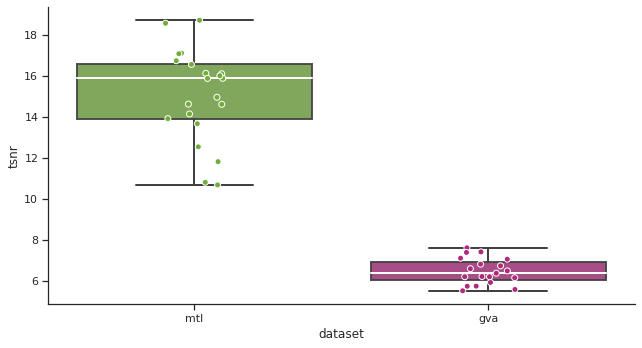

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks",  font='sans-serif')
fig = plt.figure()

colors=["#72ac3bff","#b0297dff"]
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="tsnr",x="dataset",data=dataframe, kind="box", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
              boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(10,5)

sns.stripplot(x="dataset", y="tsnr",data=dataframe,
             size=6, palette=colors, linewidth=1,edgecolor='white',dodge=True)



In [197]:
q1, q3 =np.percentile(dataframe['tsnr'][dataframe['dataset']=='mtl'],[25,75])
iqr=q3-q1
print("* 'mtl', median: " + str(np.round(dataframe['tsnr'][dataframe['dataset']=='mtl'].median(),2)) + " ["+str(np.round(iqr,2)) + "]")

q1, q3 =np.percentile(dataframe['tsnr'][dataframe['dataset']=='gva'],[25,75])
iqr=q3-q1
print("* 'gva', median: " + str(np.round(dataframe['tsnr'][dataframe['dataset']=='gva'].median(),2)) + " ["+str(np.round(iqr,2)) + "]")

* 'mtl', median: 15.86 [2.65]
* 'gva', median: 6.36 [0.9]


In [183]:
%%R -i dataframe
library(lme4); library(emmeans); library(car) #library(lmerTest); 

# Linear models with kmax as fixed factor:
print(" ")
print('linear model  __________________________________________________')
LM=lm('tsnr ~ dataset ', REML = FALSE,data=dataframe); 
print(Anova(LM))


[1] " "
[1] "linear model  __________________________________________________"
Anova Table (Type II tests)

Response: tsnr
          Sum Sq Df F value    Pr(>F)    
dataset   739.60  1  256.52 < 2.2e-16 ***
Residuals 109.56 38                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Figure 2  – FD

In [179]:
Files_FD={};meanFD={}
# Select datas
params_data_all=pd.DataFrame({'dataset': [0],'subject_name': [0],'FD_x': [0],'FD_y': [0],'FD_mean': [0]})
for dataset in ["mtl","gva"]:
    Files_FD[dataset]=[]; meanFD[dataset]=[]
    for sbj_nb in range(len(config["list_subjects"][dataset])):
        subject_name=config["list_subjects"][dataset][sbj_nb]
        if dataset=="mtl":
            directory= (config["data"][dataset]["Prepross"]['dir_stratals'] if subject_name[0] =="A" else config["data"][dataset]["Prepross"]['dir_bmpd'])
                       
        elif dataset=="gva":
            directory=config["data"][dataset]["Prepross"]['dir']
        
        Files_FD[dataset].append(glob.glob(directory+ "/sub-" + subject_name + "/func/QC_mectrics/spinalcord/Diff_displacement__sc.txt")[0])
            
        
        params_data=pd.read_csv(Files_FD[dataset][sbj_nb], ',', header=None).T
        params_data=params_data.rename(columns={0:"FD_x",1:"FD_y"})
        #params_data=pd.concat((params_data,pd.DataFrame([np.mean([params_data["FD_x"],params_data["FD_y"]])]),dataset),axis=1)
        params_data=pd.concat((pd.DataFrame({"dataset":[dataset]}),pd.DataFrame({"subject_name":[subject_name]}),params_data,pd.DataFrame({"FD_mean":[np.mean([params_data["FD_x"],params_data["FD_y"]])]})),axis=1)
    
        params_data_all=pd.concat((params_data_all,params_data))
params_data_all=params_data_all[1:]

params_data_all.to_csv(config["main_dir"]+"/ICA/results_spine_only/results/FD/fd_dataframe.csv")

In [195]:
q1, q3 =np.percentile(params_data_all['FD_mean'][params_data_all['dataset']=='mtl'],[25,75])
iqr=q3-q1
print("* 'mtl', median: " + str(np.round(params_data_all['FD_mean'][params_data_all['dataset']=='mtl'].median(),2)) + " ["+str(np.round(iqr,2)) + "]")

q1, q3 =np.percentile(params_data_all['FD_mean'][params_data_all['dataset']=='gva'],[25,75])
iqr=q3-q1
print("* 'gva', median: " + str(np.round(params_data_all['FD_mean'][params_data_all['dataset']=='gva'].median(),2)) + " ["+str(np.round(iqr,2)) + "]")

* 'mtl', median: 0.1 [0.04]
* 'gva', median: 0.1 [0.03]


In [ ]:
median Dice coefficient [interquartile range, IQR]

<Figure size 432x288 with 0 Axes>

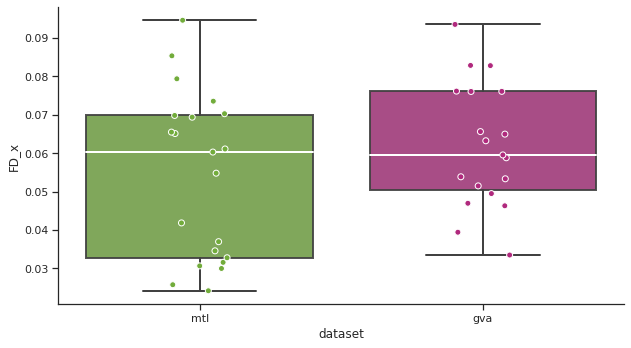

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks",  font='sans-serif')
fig = plt.figure()

colors=["#72ac3bff","#b0297dff"]
sns.set(style="ticks",  font='sans-serif')
g=sns.catplot(y="FD_x",x="dataset",data=params_data_all, kind="box", legend=True, legend_out=True,
             linewidth=2,medianprops=dict(color="white"),palette=colors, 
              boxprops=dict(alpha=.9),fliersize=0, aspect=1) #fliersize=0)
g.fig.set_size_inches(10,5)

sns.stripplot(x="dataset", y="FD_x",data=params_data_all,
             size=6, palette=colors, linewidth=1,edgecolor='white',dodge=True)



In [184]:
%%R -i params_data_all
library(lme4); library(emmeans); library(car) #library(lmerTest); 

# Linear models with kmax as fixed factor:
print(" ")
print('linear model  __________________________________________________')
LM=lm('FD_mean ~ dataset ', REML = FALSE,data=params_data_all); 
print(Anova(LM))

[1] " "
[1] "linear model  __________________________________________________"
Anova Table (Type II tests)

Response: FD_mean
            Sum Sq Df F value Pr(>F)
dataset   0.001360  1  1.4377 0.2379
Residuals 0.035956 38               
